# `Промышленное машинное обучение на Spark`
## `Задание 03: Spark ML`
<span style="color:red">Дедлайн: отсутствует</span>

<span style="color:red">В данном ноутбуке находится пример решения ML задачи с использованием `pandas` и `sklearn`. Ваша задача повторить содержимое этого ноутбука с использованием `Spark`.</span>

<span style="color:red"><b>Обратите внимание, что решение задания нужно выполнить в ноутбуке `[Spark] Task 03.ipynb`.</b></span>

## `Подключение необходимых библиотек`

In [1]:
import os
from collections import defaultdict

import tqdm.notebook as tqdm

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
import matplotlib_inline
import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
%matplotlib inline

## `Загрузка и считывание данных`

Скачаем и распакуем данные из соревнования [Mobile Price Classification](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification).


In [2]:
path = './mobile-price-classification'

import json
import os
import requests
import wget
import urllib.request
import zipfile


folder_url = 'https://disk.yandex.ru/d/Zmrxvz_g8ZyOpQ'
file_url = '/mobile_price.zip'

# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url}) 

# 'парсинг' ссылки на скачивание
data_link = response.json()['href'] 	

archive_filename = "mobile_price.zip"
urllib.request.urlretrieve(data_link, archive_filename)


with zipfile.ZipFile(archive_filename, 'r') as zip_ref:
    zip_ref.extractall(path)

os.remove(archive_filename)

In [4]:
# 01
df_test = pd.read_csv(os.path.join(path, 'test.csv'))
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

Проверим, что данные загрузились корректно. Также, посмотрим на доступные признаки и их типы:

In [5]:
# 02
df_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
# 03
df_test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [7]:
# 04
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [8]:
# 05
df_train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


В данной задании необходимо решить задачу мультиклассовой классификации с целевой переменной `price_range`.

## `EDA и визуализация`

Визуализируем разные статитстики. 

Проанализируем наличие пропусков в данных:

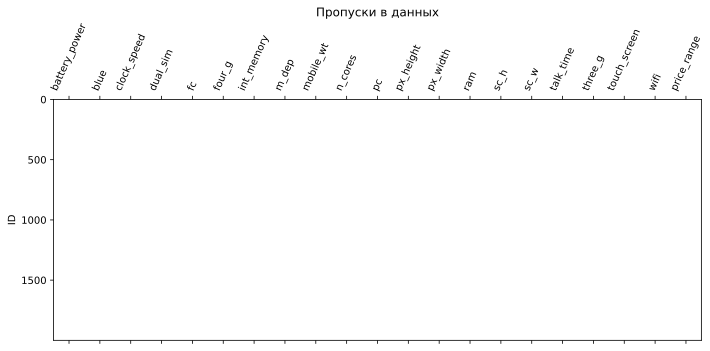

In [9]:
# 06
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.spy(df_train.isnull(), precision=0.0, aspect='auto')

ax.set_xticks(np.arange(len(df_train.columns)), labels=df_train.columns, rotation=66)
ax.set_ylabel('ID')
ax.grid(False)

ax.set_title('Пропуски в данных')

fig.tight_layout()
plt.show()

Пропусков в данных нет. Давайте для интереса посмотрим на нулевые значения в данных:

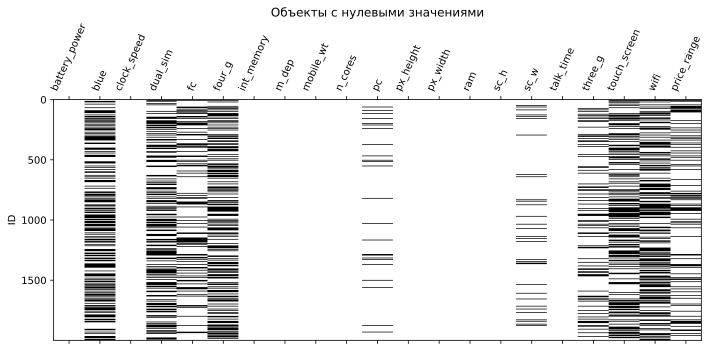

In [10]:
# 07
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.spy(df_train == 0, aspect='auto')

ax.set_xticks(np.arange(len(df_train.columns)), labels=df_train.columns, rotation=66)
ax.set_ylabel('ID')
ax.grid(False)

ax.set_title('Объекты с нулевыми значениями')

fig.tight_layout()
plt.show()

Посчитаем и изобразим попарные корреляции:

In [11]:
# 08
correlations = df_train.corr()
correlations

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
battery_power,1.000000,0.011252,0.011482,-0.041847,0.033334,0.015665,-0.004004,0.034085,0.001844,-0.029727,...,0.014901,-0.008402,-0.000653,-0.029959,-0.021421,0.052510,0.011522,-0.010516,-0.008343,0.200723
blue,0.011252,1.000000,0.021419,0.035198,0.003593,0.013443,0.041177,0.004049,-0.008605,0.036161,...,-0.006872,-0.041533,0.026351,-0.002952,0.000613,0.013934,-0.030236,0.010061,-0.021863,0.020573
clock_speed,0.011482,0.021419,1.000000,-0.001315,-0.000434,-0.043073,0.006545,-0.014364,0.012350,-0.005724,...,-0.014523,-0.009476,0.003443,-0.029078,-0.007378,-0.011432,-0.046433,0.019756,-0.024471,-0.006606
dual_sim,-0.041847,0.035198,-0.001315,1.000000,-0.029123,0.003187,-0.015679,-0.022142,-0.008979,-0.024658,...,-0.020875,0.014291,0.041072,-0.011949,-0.016666,-0.039404,-0.014008,-0.017117,0.022740,0.017444
fc,0.033334,0.003593,-0.000434,-0.029123,1.000000,-0.016560,-0.029133,-0.001791,0.023618,-0.013356,...,-0.009990,-0.005176,0.015099,-0.011014,-0.012373,-0.006829,0.001793,-0.014828,0.020085,0.021998
four_g,0.015665,0.013443,-0.043073,0.003187,-0.016560,1.000000,0.008690,-0.001823,-0.016537,-0.029706,...,-0.019236,0.007448,0.007313,0.027166,0.037005,-0.046628,0.584246,0.016758,-0.017620,0.014772
int_memory,-0.004004,0.041177,0.006545,-0.015679,-0.029133,0.008690,1.000000,0.006886,-0.034214,-0.028310,...,0.010441,-0.008335,0.032813,0.037771,0.011731,-0.002790,-0.009366,-0.026999,0.006993,0.044435
m_dep,0.034085,0.004049,-0.014364,-0.022142,-0.001791,-0.001823,0.006886,1.000000,0.021756,-0.003504,...,0.025263,0.023566,-0.009434,-0.025348,-0.018388,0.017003,-0.012065,-0.002638,-0.028353,0.000853
mobile_wt,0.001844,-0.008605,0.012350,-0.008979,0.023618,-0.016537,-0.034214,0.021756,1.000000,-0.018989,...,0.000939,0.000090,-0.002581,-0.033855,-0.020761,0.006209,0.001551,-0.014368,-0.000409,-0.030302
n_cores,-0.029727,0.036161,-0.005724,-0.024658,-0.013356,-0.029706,-0.028310,-0.003504,-0.018989,1.000000,...,-0.006872,0.024480,0.004868,-0.000315,0.025826,0.013148,-0.014733,0.023774,-0.009964,0.004399


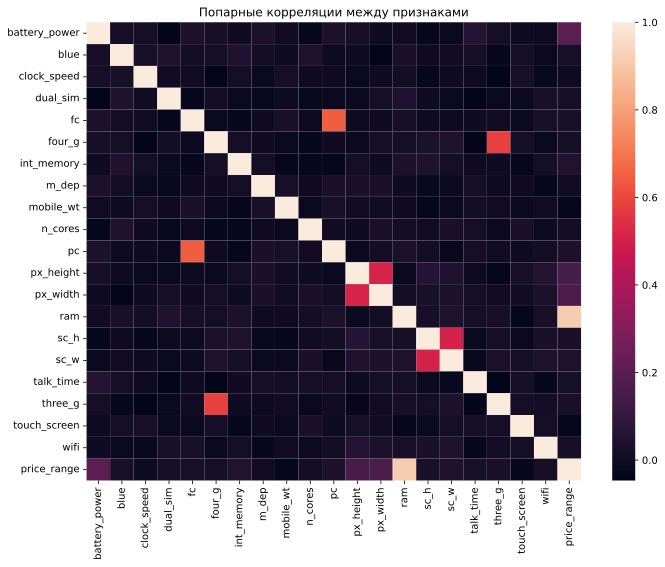

In [12]:
# 09
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(correlations, ax=ax)
ax.set_title('Попарные корреляции между признаками')

fig.tight_layout()
plt.show()

Видно, что целевая переменная сильно коррелирует с объёмом памяти в телефоне.

Посмотрим, сколько классов в данной задаче:

In [13]:
# 10
df_train['price_range'].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

В данной задаче классы сбалансированы.

Изучим распределения переменными в зависимости от таргета:

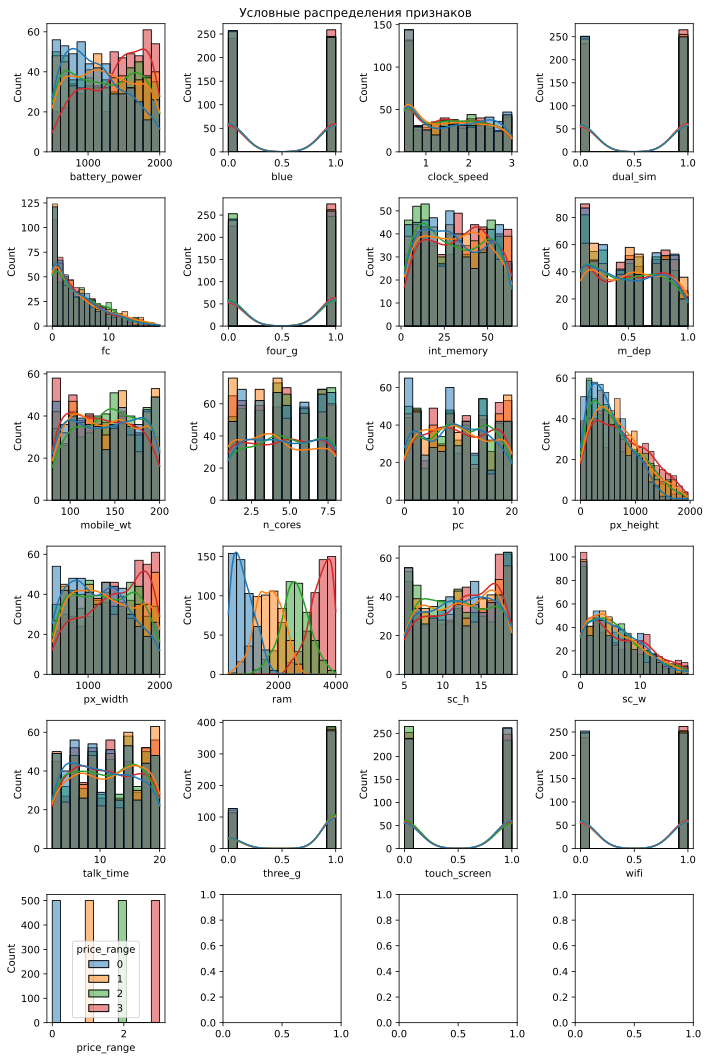

In [14]:
# 11
grid_size = np.array([6, (len(df_train.columns) - 1) // 6 + 1])
fig, axes = plt.subplots(*grid_size, figsize=2.5 * grid_size[::-1])

for ax, column in zip(axes.reshape(-1), df_train.columns):
    sns.histplot(
        df_train, x=column, hue='price_range', kde=True, palette='tab10', ax=ax, legend=column == 'price_range'
    )
    
fig.suptitle('Условные распределения признаков')

fig.tight_layout()
plt.show()

Посмотрим другие условные распределения в виде их статистик:

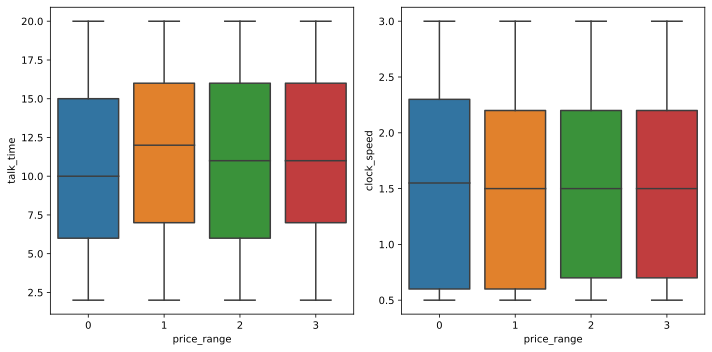

In [15]:
# 12
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x=df_train['price_range'], y=df_train['talk_time'], ax=axes[0])
sns.boxplot(x=df_train['price_range'], y=df_train['clock_speed'], ax=axes[1])

fig.tight_layout()
plt.show()

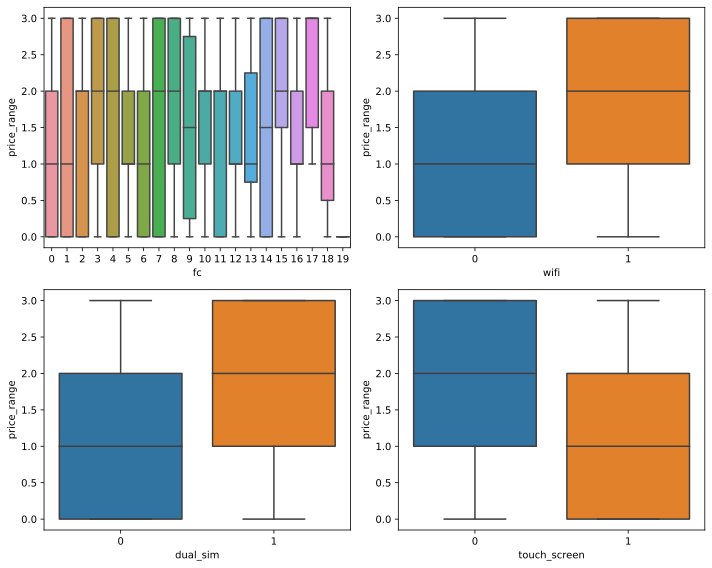

In [16]:
# 13
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.boxplot(x=df_train['fc'], y=df_train['price_range'], ax=axes[0, 0])
sns.boxplot(x=df_train['wifi'], y=df_train['price_range'], ax=axes[0, 1])
sns.boxplot(x=df_train['dual_sim'], y=df_train['price_range'], ax=axes[1, 0])
sns.boxplot(x=df_train['touch_screen'], y=df_train['price_range'], ax=axes[1, 1])

fig.tight_layout()
plt.show()

Проанализируем сетевые возможности телефонов:

In [17]:
# 14
three_g_values = df_train['three_g'].value_counts()
four_g_values = df_train['four_g'].value_counts()
three_g_values, four_g_values

(1    1523
 0     477
 Name: three_g, dtype: int64,
 1    1043
 0     957
 Name: four_g, dtype: int64)

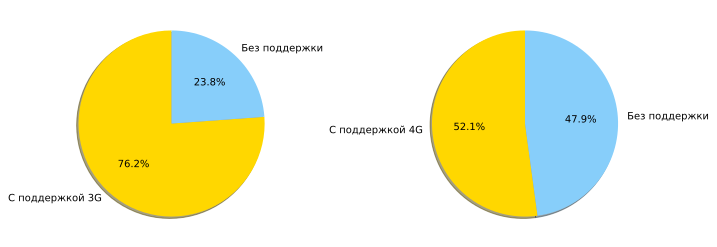

In [18]:
# 15
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].pie(
    three_g_values.values, labels=["С поддержкой 3G", 'Без поддержки'], autopct='%1.1f%%',
    shadow=True, startangle=90, colors=['gold', 'lightskyblue']
)
axes[1].pie(
    four_g_values.values, labels=["С поддержкой 4G", 'Без поддержки'], autopct='%1.1f%%',
    shadow=True, startangle=90, colors=['gold', 'lightskyblue']
)

fig.tight_layout()
plt.show()

Посмотрим информацию о качестве камер:

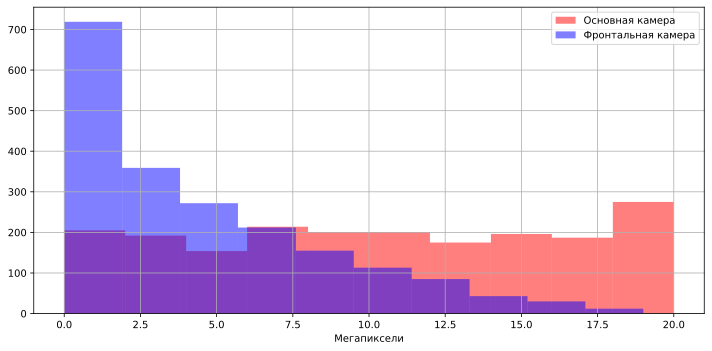

In [19]:
# 16
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist(df_train['pc'], alpha=0.5,color='red', label='Основная камера')
ax.hist(df_train['fc'], alpha=0.5, color='blue', label='Фронтальная камера')
ax.legend()
ax.grid(True)

ax.set_xlabel('Мегапиксели')

fig.tight_layout()
plt.show()

## `Обучение моделей и оценка качества`

Выполним масштабирование признаков и разбиение на обучающую и валидационную выборки:

In [20]:
# 17
X = df_train.drop('price_range', axis=1)
y = df_train['price_range']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

Обучим базовую модель — Логистическию Регрессию:

In [21]:
# 18
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

Выполним предсказания:

In [22]:
# 19
y_train_lr_pred = lr_model.predict(X_train)
y_test_lr_pred = lr_model.predict(X_test)

Посчитаем метрики:

In [23]:
# 20
print(
    'Accuracy (Train/Test): {0:.1f}%/{1:.1f}%'.format(
        100.0 * accuracy_score(y_train_lr_pred, y_train),
        100.0 * accuracy_score(y_test_lr_pred, y_test)
    )
)

print('\nConfusion Matrix', confusion_matrix(y_test_lr_pred, y_test), sep='\n')
print('\nClassification Report', classification_report(y_test_lr_pred, y_test), sep='\n')

Accuracy (Train/Test): 97.5%/97.2%

Confusion Matrix
[[161   5   0   0]
 [  0 150   3   0]
 [  0   4 140   2]
 [  0   0   3 132]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       166
           1       0.94      0.98      0.96       153
           2       0.96      0.96      0.96       146
           3       0.99      0.98      0.98       135

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



Теперь обучим более другой алгорим — Случайный Лес. Попробуем сразу выполнить подбор гиперпараметров на кроссвалидации:

In [24]:
# 21
sr_range = [0.1, 0.3, 0.7, 0.9]
max_depth_range = [1, 2, 3, 5, 8]

scores = defaultdict(lambda: defaultdict(float))

for sr in tqdm.tqdm(sr_range, leave=True):
    for max_depth in tqdm.tqdm(max_depth_range, leave=False):
        rf_model = RandomForestClassifier(
            max_samples=sr, max_depth=max_depth, n_estimators=200
        )

        scores[sr][max_depth] = cross_val_score(rf_model, X_train, y_train, cv=3)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Изобразим зависимость точности на кроссвалидации от гиперпараметров:

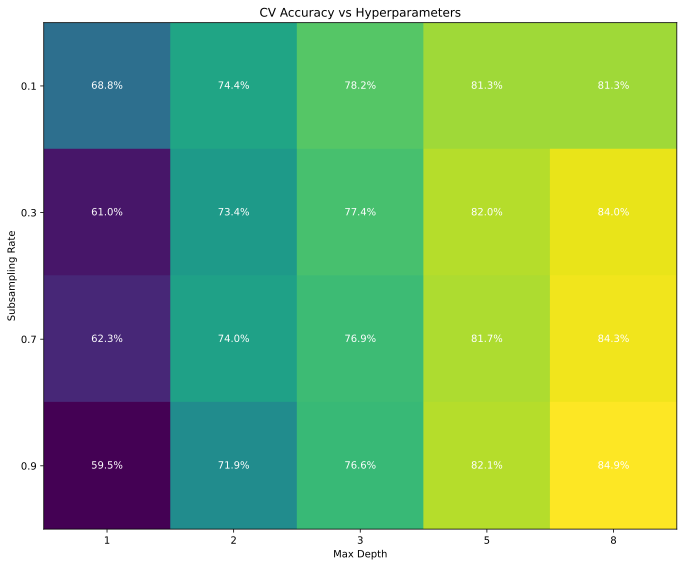

In [25]:
# 22
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

scores_array = [[np.mean(__) for __ in _.values()] for _ in scores.values()]

ax.imshow(scores_array)
for idx in range(len(sr_range)):
    for jdx in range(len(max_depth_range)):
        text = ax.text(
            jdx, idx, '{0:.1f}%'.format(100.0 * scores_array[idx][jdx]),
            ha="center", va="center", color="w"
        )

ax.set_xlabel('Max Depth')
ax.set_ylabel('Subsampling Rate')
ax.set_title('CV Accuracy vs Hyperparameters')

ax.set_xticks(np.arange(len(max_depth_range)), max_depth_range)
ax.set_yticks(np.arange(len(sr_range)), sr_range)

fig.tight_layout()
plt.show()

Обучим модель с лучшими параметрами и замерим её качество на тестовой выборке:

In [26]:
# 23
rf_model = RandomForestClassifier(
    max_samples=0.9, max_depth=8, n_estimators=200
)
rf_model.fit(X_train, y_train)

y_train_rf_pred = rf_model.predict(X_train)
y_test_rf_pred = rf_model.predict(X_test)

print(
    'Accuracy (Train/Test): {0:.1f}%/{1:.1f}%'.format(
        100.0 * accuracy_score(y_train_rf_pred, y_train),
        100.0 * accuracy_score(y_test_rf_pred, y_test)
    )
)

print('\nConfusion Matrix', confusion_matrix(y_test_rf_pred, y_test), sep='\n')
print('\nClassification Report', classification_report(y_test_rf_pred, y_test), sep='\n')

Accuracy (Train/Test): 99.4%/87.5%

Confusion Matrix
[[155  15   0   0]
 [  6 131  18   0]
 [  0  13 110   5]
 [  0   0  18 129]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       170
           1       0.82      0.85      0.83       155
           2       0.75      0.86      0.80       128
           3       0.96      0.88      0.92       147

    accuracy                           0.88       600
   macro avg       0.88      0.87      0.87       600
weighted avg       0.88      0.88      0.88       600

